In [15]:
import sys
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../rw_models')
sys.path.append('rw_models')

from rw_optim import predict_exp

base_path = '/u/jschubert/learning_bias/humans/optimism/data/'
from glob import glob

dfs = [pd.read_csv(path) for path in glob('/u/jschubert/learning_bias/llm/optim_bias/data/claude-1/run_*.csv')]
df = pd.concat(dfs, ignore_index=True).drop(columns=['Unnamed: 0'])
df['casino'] = df['casino']-1
df_sim = df

# set regret to 0 if choice = 1, else set to 1
df_sim['regret'] = df_sim['choice'].apply(lambda x: 0 if x==1 else 1)
# count trials for each casino seperately from 0 to 23
df_sim['trial_casino'] = df_sim.groupby(['run', 'casino']).cumcount()


In [16]:
df_sim

,run,trial,casino,mean0,mean1,reward0,reward1,choice,rewards,regret,trial_casino
0,37,0,1,0.25,0.75,0.0,1.0,0,0.0,1,0
1,37,1,1,0.25,0.75,0.0,1.0,1,1.0,0,1
2,37,2,1,0.25,0.75,0.0,1.0,1,1.0,0,2
3,37,3,0,0.25,0.25,1.0,0.0,1,0.0,0,0
4,37,4,1,0.25,0.75,1.0,1.0,1,1.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
4795,20,91,0,0.25,0.25,0.0,0.0,1,0.0,0,21
4796,20,92,3,0.75,0.75,1.0,1.0,1,1.0,0,23
4797,20,93,0,0.25,0.25,0.0,1.0,1,1.0,0,22
4798,20,94,0,0.25,0.25,1.0,0.0,1,0.0,0,23


<Axes: xlabel='trial_casino', ylabel='regret'>

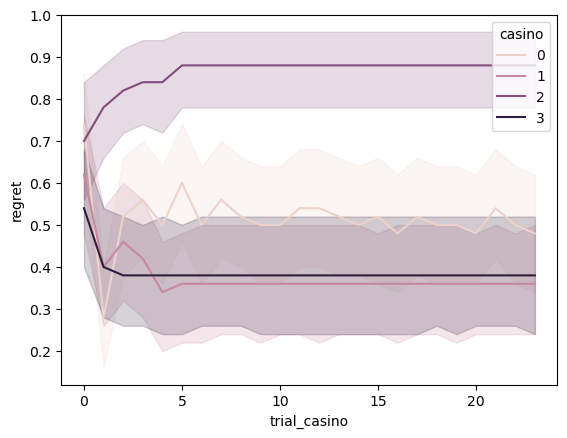

In [18]:
sns.lineplot(data=df_sim, x='trial_casino', y='regret', hue='casino', errorbar=('ci', 95))

In [52]:
model_name = 'claude-1'

q_inital = np.asarray([[.25,.25],[.25,.25],[.25,.25],[.25,.25]])
random_alpha_range = (0,1) # samples uniformly in between this range as an inital guess for alpha
random_beta_range = (0,5) # and for beta respectively.
optim_bounds = ([0,1],[0, np.inf]) #alpha, beta | bounds during optimization
n_optim_inits = 10 # how often the optimization procedure is repeated

actions = df_sim.pivot(index='run',columns='trial',values='choice').values.astype(int)
rewards = df_sim.pivot(index='run',columns='trial',values='rewards').values
cues = df_sim.pivot(index='run',columns='trial',values='casino').values.astype(int)

pipeline = predict_exp(random_alpha_range, random_beta_range, q_inital, n_optim_inits, optim_bounds, concatenated_trial=False)        
df = pipeline.fit(actions,rewards,cues,bounded=True)
df['bic_dif'] = df['c_bic'] - df['pm_bic']
df['is_pm'] = df['bic_dif'] >= 0
df['c_1/b'] = 1 / df['c_b']
df['pm_1/b'] = 1 / df['pm_b']
df.to_csv("/u/jschubert/llm_experiments/optim_bias/data/claude-1/rw_fit_of_participant.csv", index=False, mode='w')

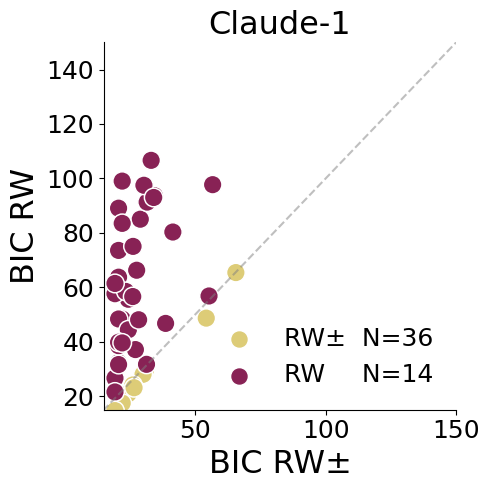

In [55]:
df = pd.read_csv("/u/jschubert/llm_experiments/optim_bias/data/claude-1/rw_fit_of_participant.csv")

import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1,1, dpi=100, figsize=(5,5), sharey=True)
title= ['Claude-1']

for i in range(1):   
    ax = axs
    plt_df = df
    sns.scatterplot( x=plt_df[('pm_bic')], y=plt_df[('c_bic')], hue=plt_df['is_pm'], ax=ax, palette=['#DDCC77', '#882255'], s=180)
    sns.despine(ax=ax)
    ax.plot([0,150],[0,150],linestyle='dashed',color='grey',alpha=.5)
    ax.set_xlim((15,150))
    ax.set_ylim((15,150))
    ax.set_ylabel('BIC RW', fontsize=23)
    ax.set_xlabel('BIC RW±', fontsize=23)
    ax.tick_params(labelsize=18)
    rwpm = str(np.sum(plt_df.is_pm))
    nrwpm = str(np.sum(~plt_df.is_pm))

    ax.set_title(title[i], fontsize=23)

    # replace legend with text "Subjects" False = RW, True = RW±
    handles, labels = ax.get_legend_handles_labels()
    order=[1,0]
    ax.legend(handles= handles, labels=[f'RW± N='+rwpm, 'RW   N='+nrwpm], loc='lower right', frameon=False, fontsize=18, markerscale=1.8)

#plt.suptitle('Model comparison of RW and RW± in terms of BIC', fontsize=20)
#plt.suptitle("Claude-1")
plt.tight_layout()
plt.show()


fig.tight_layout()
#fig.savefig('bic.png', format='png', bbox_inches='tight')

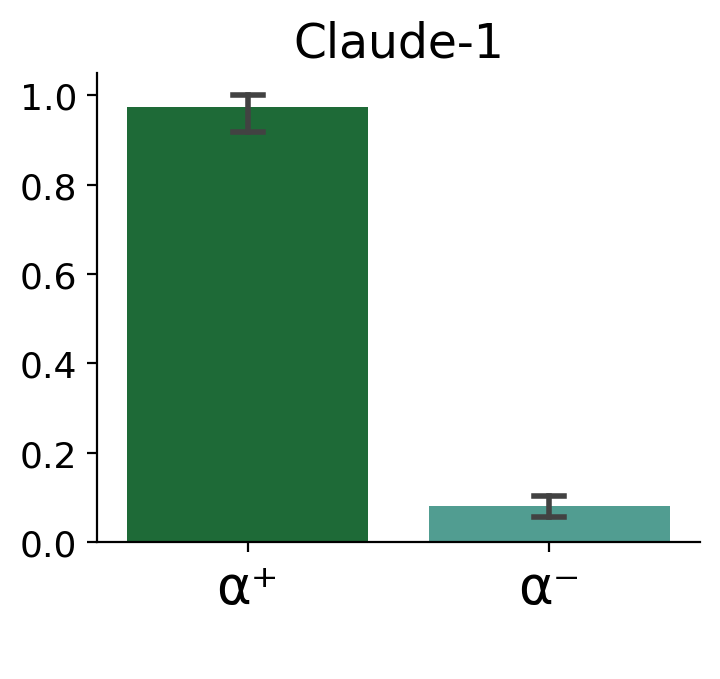

In [56]:
from statannotations.Annotator import Annotator

fig, axs = plt.subplots(1,1, figsize=(3.7,3.5), dpi=200, sharey=True)

title= ['Claude-1']

for i in range(1):   
    ax = axs
    plt_df = df
    plt_df = plt_df[plt_df.is_pm == True]
    scatter_pm = plt_df[[('p_a'),('m_a')]]
    scatter_pm_melted = scatter_pm.melt()
    fig_args = {'x': 'variable',
                'y': 'value',
                'data': scatter_pm_melted,
                'capsize':0.1,
                'errwidth':2,
                'palette': ['#117733', '#44AA99']}
    pairs = [(('p_a', 'm_a'))]


    sns.barplot(ax=ax, **fig_args)
    sns.despine(ax=ax)
    ax.set_xticklabels(['α⁺','α⁻'], fontsize=19)
    ax.set_ylabel('')
    ax.set_xlabel(' ', fontsize=13)
    ax.tick_params(axis='y',labelsize=13)
    rwpm = np.sum(plt_df.is_pm)
    nrwpm = np.sum(~plt_df.is_pm)
    ax.set_title(title[i], fontsize=17)

    configuration = {'test': 't-test_ind',
                    'comparisons_correction':None,
                    'text_format':'star'}
    #annotator = Annotator(ax=ax, pairs=pairs, **fig_args, plot='barplot')
    #annotator.configure(**configuration).apply_test().annotate()
#plt.suptitle('Learning Rates of “RW± fits”',fontsize=20)
plt.tight_layout()
plt.show()
fig.tight_layout()
#fig.savefig('lr.pdf', format='pdf', bbox_inches='tight')

In [48]:
df.describe()[['p_a', 'm_a', 'pm_b']].round(2)

,p_a,m_a,pm_b
count,11.0,11.00,11.00
mean,1.0,0.09,286.76
std,0.0,0.05,189.38
min,1.0,0.00,27.84
25%,1.0,0.05,129.65
50%,1.0,0.08,333.40
75%,1.0,0.13,422.25
max,1.0,0.16,565.65
